# Reti neurali ricorrenti

## Alcohol sales dataset

### Carico le librerie utili per l'analisi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Input,Activation,SimpleRNN,LSTM,GRU
from tensorflow.keras.callbacks import EarlyStopping

from prophet import Prophet

from warnings import filterwarnings
filterwarnings('ignore')

sns.set()

### Carico correttamente il dataset
* leggo la colonna Date in formato data
* imposto la colonna Date come indice del dataset

In [2]:
df=pd.read_csv('./data/alcohol_sales.csv',parse_dates=['Date'],index_col='Date')

### Visualizzo le prime e ultime righe del dataset

In [3]:
df.head(3)

,Sales
Date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002


In [4]:
df.tail(3)

,Sales
Date,
2019-10-01,14427
2019-11-01,13773
2019-12-01,16197


### Visualizzo graficamente l'andamento della serie

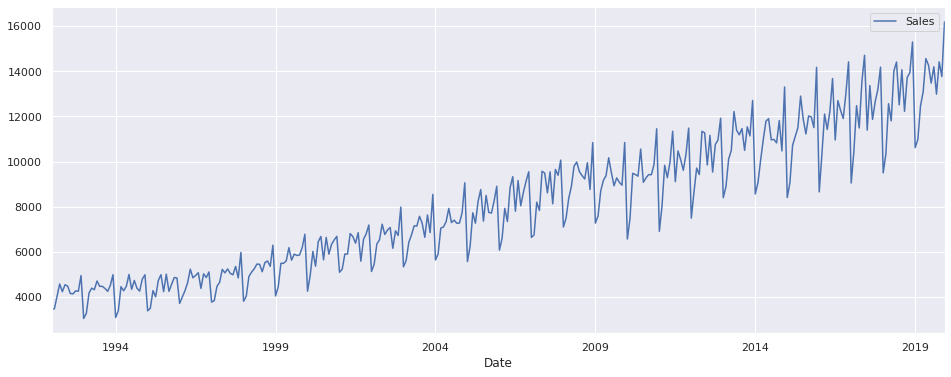

In [5]:
df.plot(figsize=(16, 6));

### Scompongo la serie in trend, stagionalità e residui con statsmodels

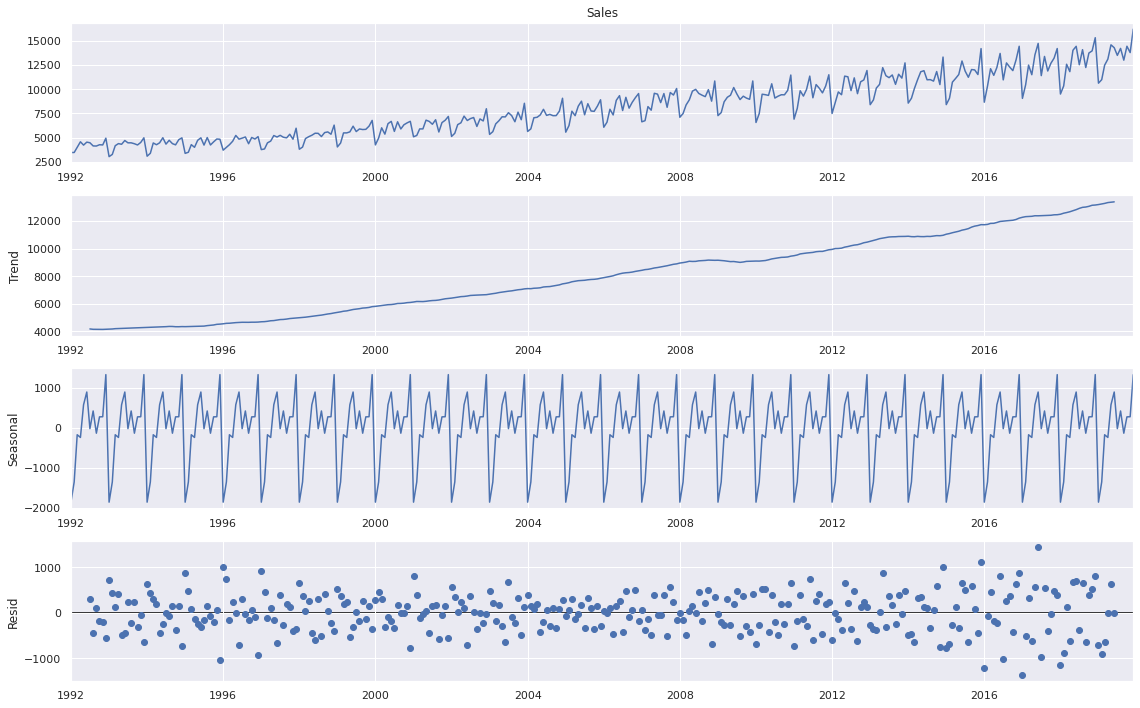

In [6]:
plt.rcParams["figure.figsize"] = (16, 10)
decomposition = seasonal_decompose(df['Sales']);
decomposition.plot();

### Divido il dataset in set train e test set, quest'ultimo lo creiamo per il solo anno 2019

In [7]:
df_train = df[:"2018"]
df_test = df["2019"]

In [8]:
df_train.tail(4)

,Sales
Date,
2018-09-01,12231
2018-10-01,13727
2018-11-01,13949
2018-12-01,15308


In [9]:
df_test.tail(4)

,Sales
Date,
2019-09-01,12992
2019-10-01,14427
2019-11-01,13773
2019-12-01,16197


### Scalo i dati in un range tra 0 ed 1 con MinMaxScaler

In [10]:
mms= MinMaxScaler()
mms.fit(df_train)

MinMaxScaler()

In [11]:
train_scaled = mms.transform(df_train)
test_scaled = mms.transform(df_test)

### TimeSeriesGenerator
A questo punto, è necessario processare i dati facendo in modo che data una sequenza di n mesi, si possa prevedere il mese successivo. Per fare ciò, utilizzo il metodo TimeSeriesGenerator di keras, che prendendo in input i dati di training, li suddivide automaticamente in features e target in base ai parametri che gli passo. L'obiettivo è quello di prevedere un mese nel futuro dati i 12 mesi precedenti, per fare ciò svolgo i seguenti passaggi:
* importo il modulo TimeseriesGenerator dal branch tensorflow.keras.preprocessing.sequence,
* istanzio l'oggetto TimeSeriesGenerator impostando i parametri.

In [12]:
generator=TimeseriesGenerator(data=train_scaled, targets=train_scaled, length=12, batch_size=1)

### Una volta instanziato il generatore, estraggo il primo valore e ne visualizzo il risultato

In [13]:
X, y = generator[0]

In [14]:
X.flatten()


array([0.03486194, 0.03478048, 0.07909098, 0.12486764, 0.09692922,
       0.12201678, 0.11688523, 0.09008715, 0.08919117, 0.10002444,
       0.09847683, 0.1551682 ])

In [15]:
y

array([[0.]])

In [16]:
df_new = []
for X, y in generator:
    df_new.append({"features": X.flatten(), "target": y[0][0]})
    
df_generator = pd.DataFrame(df_new)

In [17]:
df_generator.head()

,features,target
0,"[0.0348619369552822, 0.03478048383155494, 0.07...",0.000000
1,"[0.03478048383155494, 0.07909098313920335, 0.1...",0.018734
2,"[0.07909098313920335, 0.1248676386739431, 0.09...",0.091961
3,"[0.1248676386739431, 0.09692921723548095, 0.12...",0.109636
4,"[0.09692921723548095, 0.12201677934348779, 0.1...",0.103934


In [18]:
df_generator.shape # vedo la shape di df_generetor perchè al prossimo passo mi servirà per creare la rete neurale

(312, 2)

### Definisco vari modelli di rete neurale e nelle specifico i seguenti:
* SimpleRNN
* LSTM
* LSTM multistrato
* GRU

In [19]:
def model_rnn (activation):
    model = Sequential()
    model.add(SimpleRNN(312,activation=activation,name='input_embedding_layer',input_shape=(12,1)))
    model.add(Dense(6, activation = activation, name = 'hidden_layer'))
    model.add(Dense(1, activation = activation, name = 'output_layer'))
    model.compile(loss='huber', optimizer='adam', metrics=['mse'])
    return model

def model_lstm ():
    model = Sequential()
    model.add(LSTM(312,activation='relu',name='input_embedding_layer',input_shape=(12,1)))
    model.add(Dense(1, activation = 'sigmoid', name = 'output_layer'))
    model.compile(loss='huber', optimizer='adam', metrics=['mse'])
    return model

def model_multi_lstm ():
    model = Sequential()
    model.add(LSTM(312, activation='relu',name='input_embedding_layer',input_shape=(12,1)))
    model.add(Dense(6, activation = 'relu', name = 'hidden_layer'))
    model.add(Dense(1, activation = 'sigmoid', name = 'output_layer'))
    model.compile(loss='huber', optimizer='adam', metrics=['mse'])
    return model

def model_gru ():
    model = Sequential()
    model.add(GRU(312, activation='relu',name='input_embedding_layer',input_shape=(12,1)))
    model.add(Dense(6, activation = 'relu', name = 'hidden_layer'))
    model.add(Dense(1, activation = 'sigmoid', name = 'output_layer'))
    model.compile(loss='huber', optimizer='adam', metrics=['mse'])
    return model

### RNN tanh

In [20]:
rnn_tanh = model_rnn(activation="tanh")
rnn_tanh.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding_layer (Simpl (None, 312)               97968     
_________________________________________________________________
hidden_layer (Dense)         (None, 6)                 1878      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 7         
Total params: 99,853
Trainable params: 99,853
Non-trainable params: 0
_________________________________________________________________


### RNN relu

In [21]:
rnn_relu = model_rnn (activation="relu")
rnn_relu.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding_layer (Simpl (None, 312)               97968     
_________________________________________________________________
hidden_layer (Dense)         (None, 6)                 1878      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 7         
Total params: 99,853
Trainable params: 99,853
Non-trainable params: 0
_________________________________________________________________


### LSTM

In [22]:
lstm= model_lstm()
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding_layer (LSTM) (None, 312)               391872    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 313       
Total params: 392,185
Trainable params: 392,185
Non-trainable params: 0
_________________________________________________________________


### LSTM multistrato

In [23]:
multi_lstm = model_multi_lstm()
multi_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding_layer (LSTM) (None, 312)               391872    
_________________________________________________________________
hidden_layer (Dense)         (None, 6)                 1878      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 7         
Total params: 393,757
Trainable params: 393,757
Non-trainable params: 0
_________________________________________________________________


### GRU

In [24]:
gru= model_gru()
gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding_layer (GRU)  (None, 312)               294840    
_________________________________________________________________
hidden_layer (Dense)         (None, 6)                 1878      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 7         
Total params: 296,725
Trainable params: 296,725
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping
Durante l'addestramento del modello, è possibile fermare la fase di training nel caso in cui il modello non dovesse migliorare con l'avanzare delle epoche. Per fare ciò, utilizzo il metodo EarlyStopping di keras:
* importo il modulo EarlyStopping dal branch tensorflow.keras.callbacks
* instanzio l'oggetto EarlyStopping impostando i  parametri

In [25]:
es = EarlyStopping(monitor='loss', min_delta=1e-5,patience=5,mode='min')

### Fit dei modelli sui dati
Avendo creato un generatore, al posto del metodo fit per addestrare il modello è necessario utilizzare il metodo fit_generator
* per utilizzare l'EarlyStopping, aggiungo nel parametro callbacks l'oggetto EarlyStopping dentro una lista

### RNN

> ### tanh

In [26]:
history_rnn_tanh=rnn_tanh.fit_generator(generator,callbacks=es,epochs=100)

Epoch 1/100
312/312 [==============================] - 4s 10ms/step - loss: 0.0163 - mse: 0.0327
Epoch 2/100
312/312 [==============================] - 3s 9ms/step - loss: 0.0028 - mse: 0.0056
Epoch 3/100
312/312 [==============================] - 3s 10ms/step - loss: 0.0050 - mse: 0.0100
Epoch 4/100
312/312 [==============================] - 3s 10ms/step - loss: 0.0038 - mse: 0.0076
Epoch 5/100
312/312 [==============================] - 3s 10ms/step - loss: 0.0037 - mse: 0.0075
Epoch 6/100
312/312 [==============================] - 3s 10ms/step - loss: 0.0034 - mse: 0.0068
Epoch 7/100
312/312 [==============================] - 3s 9ms/step - loss: 0.0050 - mse: 0.0101


> ### relu

In [27]:
history_rnn_relu=rnn_relu.fit_generator(generator,callbacks=es,epochs=100)

Epoch 1/100
312/312 [==============================] - 4s 10ms/step - loss: 0.1135 - mse: 0.2270
Epoch 2/100
312/312 [==============================] - 3s 10ms/step - loss: 0.1036 - mse: 0.2071
Epoch 3/100
312/312 [==============================] - 3s 10ms/step - loss: 0.0999 - mse: 0.1998
Epoch 4/100
312/312 [==============================] - 3s 9ms/step - loss: 0.1123 - mse: 0.2247
Epoch 5/100
312/312 [==============================] - 3s 9ms/step - loss: 0.1106 - mse: 0.2212
Epoch 6/100
312/312 [==============================] - 3s 9ms/step - loss: 0.1066 - mse: 0.2132


### LSTM

In [28]:
history_lstm=lstm.fit_generator(generator,callbacks=es,epochs=100)

Epoch 1/100
312/312 [==============================] - 9s 26ms/step - loss: 0.0165 - mse: 0.0330
Epoch 2/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0042 - mse: 0.0084
Epoch 3/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0038 - mse: 0.0075
Epoch 4/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0044 - mse: 0.0089
Epoch 5/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0029 - mse: 0.0059
Epoch 6/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0023 - mse: 0.0047
Epoch 7/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0017 - mse: 0.0033
Epoch 8/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0024 - mse: 0.0048
Epoch 9/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0013 - mse: 0.0027
Epoch 10/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0013 - mse: 0.0026
Epoch 11/100
312/312 [=======

> ### multistrato

In [29]:
history_multi_lstm=multi_lstm.fit_generator(generator,callbacks=es,epochs=100)

Epoch 1/100
312/312 [==============================] - 10s 28ms/step - loss: 0.0226 - mse: 0.0452
Epoch 2/100
312/312 [==============================] - 8s 27ms/step - loss: 0.0041 - mse: 0.0082
Epoch 3/100
312/312 [==============================] - 8s 24ms/step - loss: 0.0041 - mse: 0.0081
Epoch 4/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0033 - mse: 0.0065
Epoch 5/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0028 - mse: 0.0056
Epoch 6/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0018 - mse: 0.0036
Epoch 7/100
312/312 [==============================] - 7s 21ms/step - loss: 0.0019 - mse: 0.0038
Epoch 8/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0022 - mse: 0.0045
Epoch 9/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0015 - mse: 0.0030
Epoch 10/100
312/312 [==============================] - 7s 22ms/step - loss: 0.0013 - mse: 0.0027
Epoch 11/100
312/312 [======

### GRU

In [30]:
history_gru=gru.fit_generator(generator,callbacks=es,epochs=100)

Epoch 1/100
312/312 [==============================] - 9s 25ms/step - loss: 0.0319 - mse: 0.0638
Epoch 2/100
312/312 [==============================] - 7s 23ms/step - loss: 0.0279 - mse: 0.0558
Epoch 3/100
312/312 [==============================] - 7s 21ms/step - loss: 0.0297 - mse: 0.0595
Epoch 4/100
312/312 [==============================] - 6s 21ms/step - loss: 0.0246 - mse: 0.0493
Epoch 5/100
312/312 [==============================] - 6s 20ms/step - loss: 0.0281 - mse: 0.0562
Epoch 6/100
312/312 [==============================] - 6s 19ms/step - loss: 0.0265 - mse: 0.0529
Epoch 7/100
312/312 [==============================] - 6s 19ms/step - loss: 0.0285 - mse: 0.0570
Epoch 8/100
312/312 [==============================] - 6s 19ms/step - loss: 0.0263 - mse: 0.0526
Epoch 9/100
312/312 [==============================] - 6s 19ms/step - loss: 0.0284 - mse: 0.0568
Epoch 10/100
312/312 [==============================] - 6s 20ms/step - loss: 0.0258 - mse: 0.0517
Epoch 11/100
312/312 [=======

### Visualizzo graficamente l'history dei diversi modelli

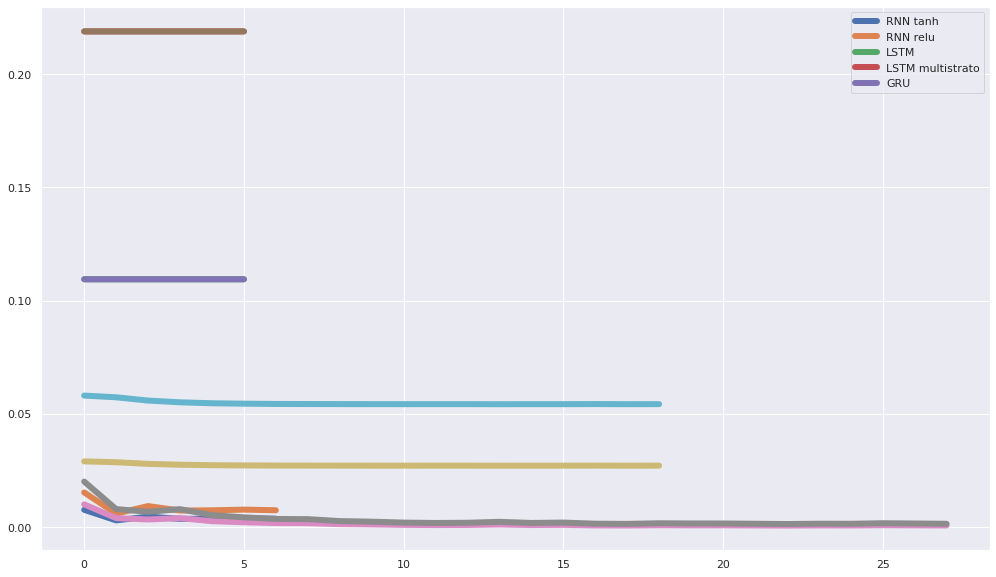

In [31]:
fig = plt.figure(figsize=(17, 10))
ax = fig.subplots()
pd.DataFrame(history_rnn_tanh.history).plot(linewidth=6,ax=ax)
pd.DataFrame(rnn_relu.history.history).plot(linewidth=6,ax=ax)
pd.DataFrame(history_rnn_relu.history).plot(linewidth=6,ax=ax)
pd.DataFrame(history_lstm.history).plot(linewidth=6,ax=ax)
pd.DataFrame(history_gru.history).plot(linewidth=6,ax=ax)
ax.legend(["RNN tanh","RNN relu", "LSTM", "LSTM multistrato", "GRU"])
fig.show()

### Effettuo le previsioni sui dati di test
Per effetuare le previsioni utilizzo la funzione get_model_predictions 

In [32]:
def model_predictions (train,test,model):
    y_hat = []
    batch = train[-12:].reshape((1, 12, 1))
    for i in range(len(test)):
        # si calcola la previsione 1 mese in avanti 
        # ([0] è per recuperare il valore numerico al posto dell'intero array)
        new_pred = model.predict(batch)[0]
        # salvataggio previsioni
        y_hat.append(new_pred)
        # aggiornamento batch per includere le previsioni ed eliminare il primo valore
        batch = np.append(arr=batch[:, 1:, :], values=[[new_pred]], axis=1)
    return y_hat

In [33]:
rnn_tanh_pred = model_predictions(train=train_scaled, test=test_scaled, model=rnn_tanh)
rnn_relu_pred = model_predictions(train=train_scaled, test=test_scaled, model=rnn_relu)
lstm_pred = model_predictions(train=train_scaled, test=test_scaled, model=lstm)
multi_lstm_pred = model_predictions(train=train_scaled, test=test_scaled, model=multi_lstm)
gru_pred = model_predictions(train=train_scaled, test=test_scaled, model=gru)

### Le previsioni che ho precedentemente effettuate sono scalate in un range tra 0 ed 1, è possibile riportarle alla loro dimensione originale utilizzando il metodo inverse_transform del MinMaxScaler

In [34]:
rnn_tanh_pred = mms.inverse_transform(rnn_tanh_pred)
rnn_relu_pred = mms.inverse_transform(rnn_relu_pred)
lstm_pred = mms.inverse_transform(lstm_pred)
multi_lstm_pred = mms.inverse_transform(multi_lstm_pred)
gru_pred =mms.inverse_transform(gru_pred)

### Aggiungo le previsioni del modello al dataframe contenente i valori reali delle vendite

In [35]:
df_test['RNN_tanh']=rnn_tanh_pred
df_test['RNN_relu']=rnn_relu_pred
df_test['LSTM']=lstm_pred
df_test['multi_LSTM']=multi_lstm_pred
df_test['GRU']=gru_pred
df_test

,Sales,RNN_tanh,RNN_relu,LSTM,multi_LSTM,GRU
Date,,,,,,
2019-01-01,10616,11431.987251,3031.0,10460.849319,9789.885550,8012.255989
2019-02-01,10976,11109.680086,3031.0,11338.850973,10805.221431,8012.255989
2019-03-01,12472,11618.971815,3031.0,13302.738090,12831.852379,8012.255989
2019-04-01,13098,11581.940786,3031.0,12797.784270,12274.507757,8012.255989
2019-05-01,14573,12364.433044,3031.0,14437.232587,14101.565566,8012.255989
2019-06-01,14277,12580.821439,3031.0,14618.397414,14314.362452,8012.255989
2019-07-01,13484,11965.123583,3031.0,13410.499447,12943.417457,8012.255989
2019-08-01,14205,12608.831255,3031.0,14444.393651,14101.201878,8012.255989
2019-09-01,12992,11348.835923,3031.0,13153.283620,12656.802190,8012.255989


### Visualizzo graficamente la differenza tra i dati reali ed i valori previsti dal modello

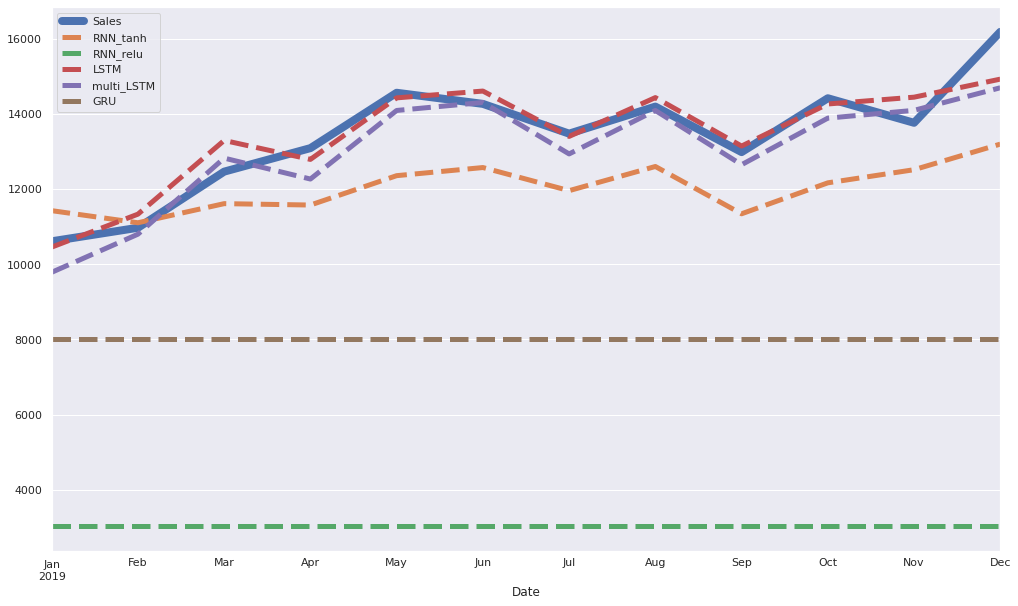

In [36]:
fig = plt.figure(figsize=(17,10));
ax = fig.subplots();
df_test["Sales"].plot(linewidth=8,linestyle="solid",ax=ax);
df_test["RNN_tanh"].plot(linewidth=5,linestyle='dashed', ax=ax);
df_test["RNN_relu"].plot(linewidth=5,linestyle="dashed", ax=ax);
df_test["LSTM"].plot(linewidth=5,linestyle="dashed", ax=ax);
df_test["multi_LSTM"].plot(linewidth=5,linestyle="dashed", ax=ax);
df_test["GRU"].plot(linewidth=5,linestyle="dashed", ax=ax);
ax.legend(["Sales", "RNN_tanh", "RNN_relu", "LSTM", "multi_LSTM", "GRU"]);

### Calcolo il rmse sulle previsioni realizzate

In [37]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [38]:
rnn_tanh_mse=rmse(df_test['RNN_tanh'],df_test['Sales'])
rnn_relu_mse=rmse(df_test['RNN_relu'],df_test['Sales'])
lstm_mse=rmse(df_test['LSTM'],df_test['Sales'])
multi_lstm_mse=rmse(df_test['multi_LSTM'],df_test['Sales'])
gru_mse=rmse(df_test['GRU'],df_test['Sales'])

In [39]:
print('RNN_tanh_mse:', rnn_tanh_mse)
print('RNN_relu_mse:', rnn_relu_mse)
print('LSTM_mse:', lstm_mse)
print('multi_LSTM_mse:', multi_lstm_mse)
print('GRU_mse:', gru_mse)

RNN_tanh_mse: 1698.3115597561343
RNN_relu_mse: 10499.0890160369
LSTM_mse: 519.5052829654728
multi_LSTM_mse: 630.5540189235217
GRU_mse: 5612.640554261225


# PROPHET

>  Utilizzo prophet per effetuare le previsioni sempre sullo stesso dataframe e vedere in fine quale modello sarà il migliore

### Suddivido il dataset in train e test

In [40]:
train_prophet = df[:"2018"]
test_prophet = df["2019"]

### Plotto una prima visualizzazione del training e test set

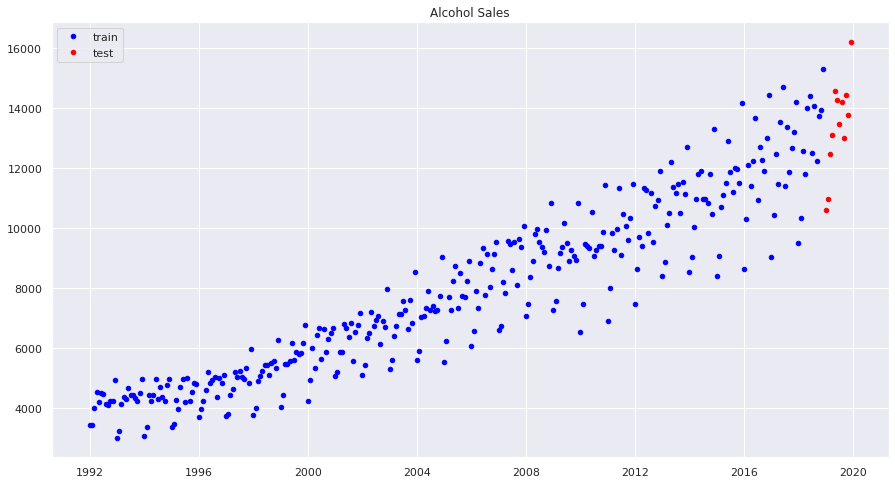

In [41]:
plt.figure(figsize=(15, 8));

plt.plot(train_prophet,
         marker='.',
         markersize=9,
         linestyle='',
         label='train',
         color='blue');

plt.plot(test_prophet,
         marker='.',
         markersize=9,
         linestyle='',
         label='test',
         color='red')

plt.title('Alcohol Sales');
plt.legend();

### Creo un dataframe da passare a Prophet. Uso reset_index di Pandas per far ritornare gli indici temporali una colonna standard

In [42]:
df_train_prophet = train_prophet.reset_index()
df_train_prophet

,Date,Sales
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
319,2018-08-01,14073
320,2018-09-01,12231
321,2018-10-01,13727
322,2018-11-01,13949


### Rinomino le colonne come vuole Prophet per poter far si che le possa elaborare, nello scpecifico con 'ds' indico la _data_ e con 'y' le _vendite_

In [43]:
df_train_prophet.columns = ['ds', 'y']
df_train_prophet

,ds,y
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
319,2018-08-01,14073
320,2018-09-01,12231
321,2018-10-01,13727
322,2018-11-01,13949


### A questo punto sono pronto per eseguire il training (la sintassi di Prophet è simile a quella di Scikit-learn)

In [44]:
prophet_model = Prophet()
prophet_model.fit(df_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Creo una variabile che conterà le previsioni del test

In [45]:
future = prophet_model.make_future_dataframe(periods=12, freq='MS',include_history=False)
future

,ds
0,2019-01-01
1,2019-02-01
2,2019-03-01
3,2019-04-01
4,2019-05-01
5,2019-06-01
6,2019-07-01
7,2019-08-01
8,2019-09-01
9,2019-10-01


### Uso la variabile _'future'_ che ho appena creato per fare le previsioni con il modello di Prophet

In [46]:
test_predictions = prophet_model.predict(future)

### Come possiamo vedere il dataframe contiene diverse colonne. La colonna _yhat_ memorizza le previsioni dei test numerici

In [47]:
test_predictions.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [48]:
test_predictions['yhat']

0     11228.138519
1     11790.837607
2     12900.920324
3     12866.630528
4     13625.907782
5     14138.624955
6     13277.288808
7     13666.867414
8     13184.211800
9     13623.427972
10    13576.743999
11    14768.099627
Name: yhat, dtype: float64


### Ora aggiungo queste predizioni al dataframe di test

In [49]:
test_prophet['Prediction'] = test_predictions['yhat'].values
test_prophet

,Sales,Prediction
Date,,
2019-01-01,10616,11228.138519
2019-02-01,10976,11790.837607
2019-03-01,12472,12900.920324
2019-04-01,13098,12866.630528
2019-05-01,14573,13625.907782
2019-06-01,14277,14138.624955
2019-07-01,13484,13277.288808
2019-08-01,14205,13666.867414
2019-09-01,12992,13184.211800


### Comparo il valore di test reale (oservato) e quello predetto con Prophet

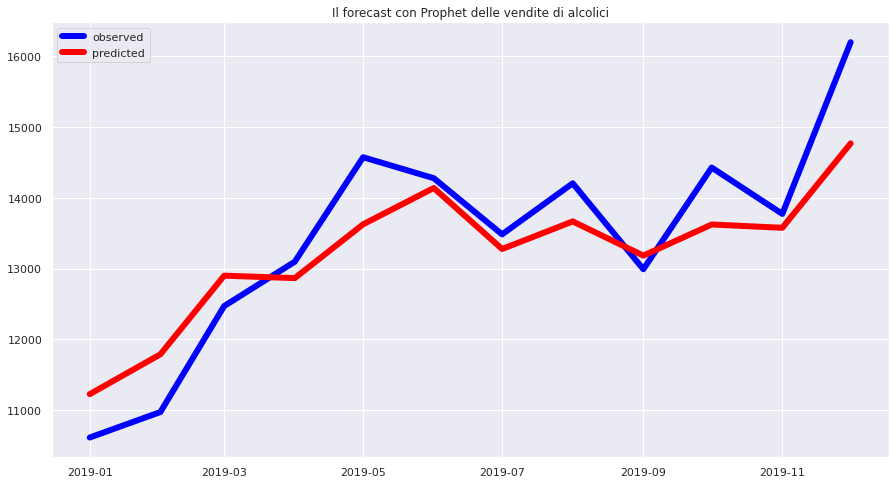

In [50]:
plt.figure(figsize=(15, 8))

plt.plot(test_prophet['Sales'],
         linewidth=6,
         linestyle='solid',
         color='blue',
         label='observed');

plt.plot(test_prophet['Prediction'],
         linewidth=6,
         linestyle='solid',
         color='red',
         label='predicted');

plt.title('Il forecast con Prophet delle vendite di alcolici')
plt.legend();

### Plotto i residui delle predizioni

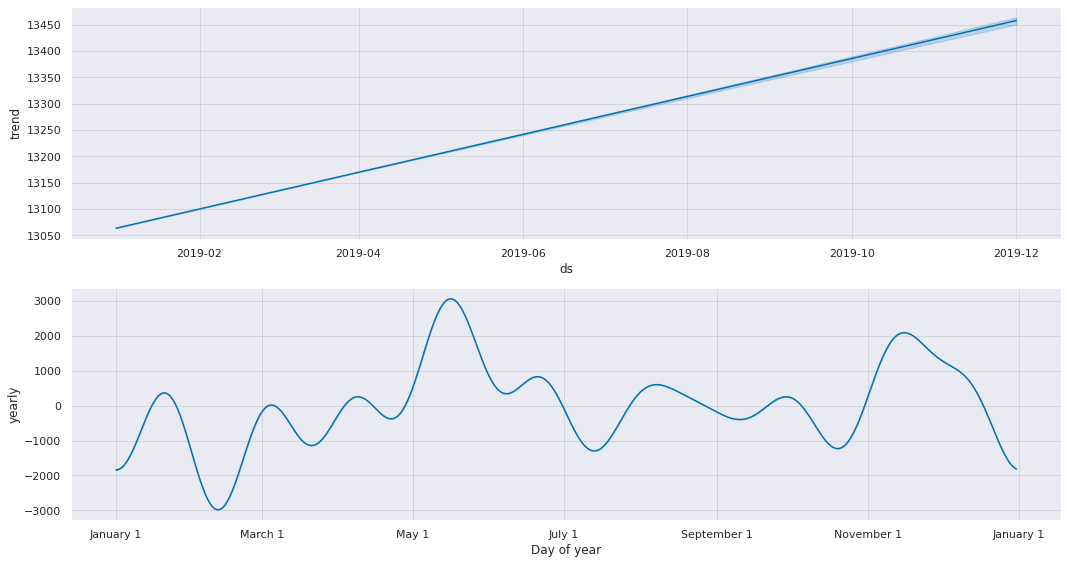

In [51]:
res = prophet_model.plot_components(test_predictions,figsize=(15, 8))

In [52]:
rmse_pred=rmse(test_prophet['Prediction'],test_prophet['Sales'])
print('Valore rmse delle predizioni con PROPHET:', rmse_pred)

Valore rmse delle predizioni con PROPHET: 663.8004194399742


_Come possiamo vedere dal valore RMSE dei vari modelli,abbiamo potuto riscontrare che anche con un modello tale quale Prophet, si raggiungono risultati molto soddisfacenti. Prophet in questo caso, ha il grande vantaggio di implicare meno fatica a livello di programmazione ma sopratutto di risorse adoperatte per creare il modello. Le reti neurali sono uno strumento molto potente ma anche molto dispendioso di risorse e tempo per trainarle._ 